# 🧠Brain Tumor Detection

 - Bu çalışmada **derin öğrenme tabanlı Convolutional Neural Network (CNN)** modeli ile MR görüntülerinden beyin tümörü tespiti amaçlanmıştır.  
Overfitting’i önlemek için farklı optimizasyon algoritmaları, öğrenme oranları, epoch sayıları ve katman düzenlemeleri denenmiş, elde edilen sonuçlar doğrultusunda en uygun model seçilmiştir.  

## 🔍 Projenin Amacı ve Önemi
  - Beyin tümörleri, erken teşhis edilmediğinde ciddi sağlık sorunlarına ve hatta ölüme yol açabilen hastalıkların başında gelir. Günümüzde MR (Manyetik Rezonans) görüntüleme, tümör tespitinde yaygın olarak kullanılan en önemli yöntemlerden biridir. Ancak bu görüntülerin incelenmesi **uzman radyologların deneyimine** bağlıdır ve **zaman alıcı** olabilir. Ayrıca insan gözü, bazı küçük veya belirsiz tümörleri gözden kaçırabilir.  

- Bu noktada **yapay zeka tabanlı otomatik sistemler**, tıbbi görüntülerin analizinde destek sağlayarak:  
   - Hekimlerin iş yükünü azaltabilir,  
   - Daha hızlı ve doğru ön tanı imkanı verebilir,  
   - Tümörün erken evrede tespit edilmesine katkı sağlayabilir,  
   - Yanlış pozitif ve negatif oranlarını azaltabilir.

## 👥 Kimler İçin Faydalı?

- **Doktorlar ve Radyologlar:** MR görüntülerini hızlı ve güvenilir bir şekilde ön değerlendirme yapmalarına yardımcı olur.  
- **Hastalar:** Erken teşhis sayesinde tedaviye daha hızlı başlanabilir.  
- **Hastaneler ve Sağlık Kurumları:** Daha kısa sürede daha fazla görüntü işlenerek sağlık hizmetlerinin verimliliği artar.  
- **Araştırmacılar ve Öğrenciler:** Yapay zeka ile tıbbi görüntü analizi çalışmalarına bir örnek oluşturur.  

## ✅ Projenin Katkıları

- **Zaman Tasarrufu:** Binlerce MR görüntüsünün kısa sürede analiz edilmesi.  
- **Destekleyici Karar Mekanizması:** Doktorların karar verme sürecine yardımcı olur, ancak onların yerine geçmez.  
- **Genelleştirilebilirlik:** Farklı tümör tipleri veya diğer hastalıkların tespitinde de kullanılabilecek altyapı sunar.  
- **Overfitting’in Önlenmesi:** Farklı optimizasyon algoritmaları, epoch sayıları ve katman tasarımlarıyla modelin aşırı öğrenme yapmasının önüne geçilmiştir.  

###   Akış Şeması
  - Kütüphane İçe Aktarım
  - Görüntü Önişleme
  - Model İle Tahmin
  - Sonucun Yorumlanması ve Görselleştirilmesi
  - Görüntü Yükleme

# 📚 Kütüphane Aktarımı

  - Aşağıdaki kodda projenin çalışması için gerekli bütün kütüphaneler içeri aktarılmıştır. 
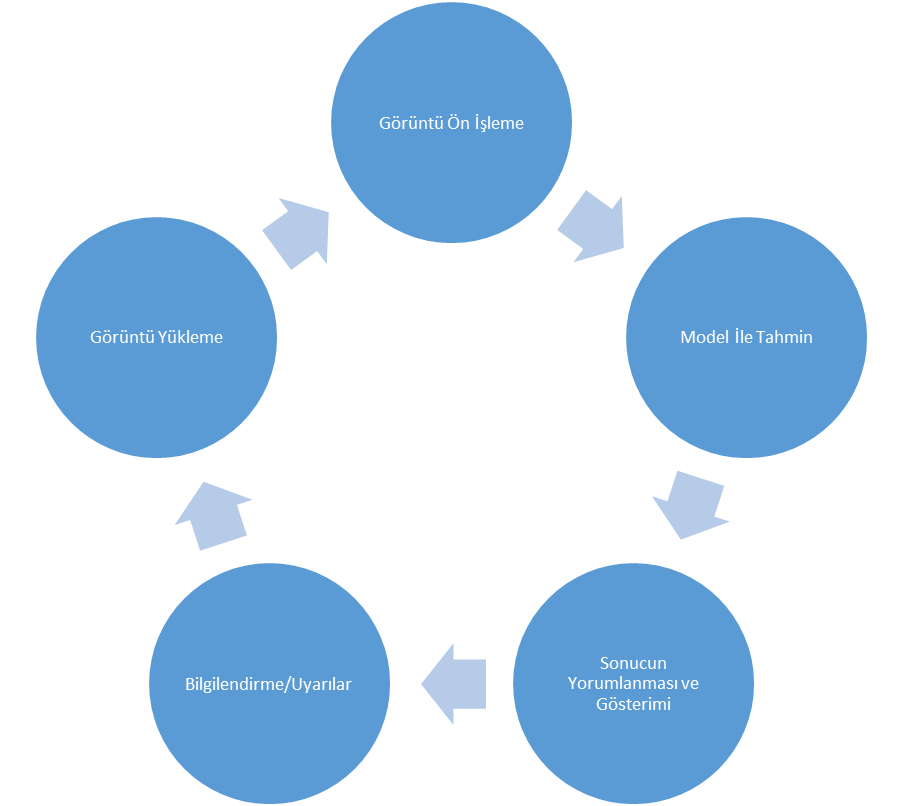
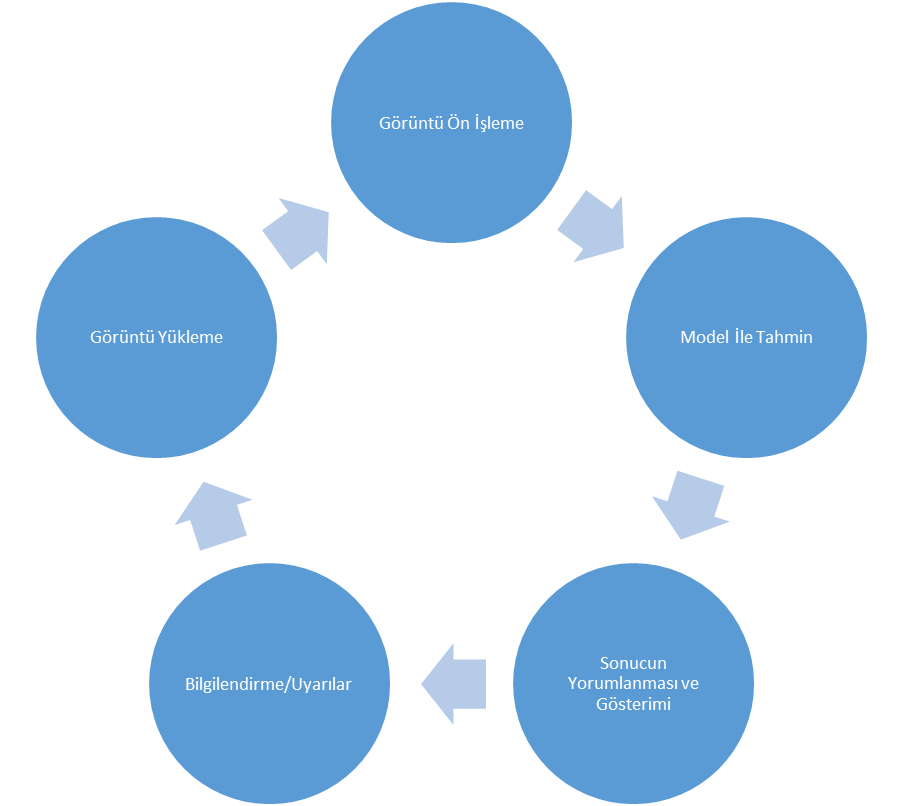

In [ ]:
import pandas as pd
import numpy as np
import cv2 
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense, BatchNormalization
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adamax, Adam, SGD , RMSprop , AdamW
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report,confusion_matrix
import warnings
import matplotlib.pyplot as plt 
warnings.filterwarnings("ignore")

# 📂 Eğitim Verisinin Hazırlanması 

- Aşağıdaki kodda , **training (eğitim) verileri** modele uygun hale getirilmiştir.  
    - `train_dr` → Eğitim veri setinin bulunduğu ana klasörün yolu belirtilmiştir.  
    - Klasör içindeki her alt klasör (ör. tümör tipleri) gezilerek:  
         - **Dosya yolları (`File Path`)**  
         - **Etiketler (`Labels`)**  
         listelenmiştir.  
     - Elde edilen bilgiler bir **DataFrame** yapısında saklanmıştır.

In [ ]:
train_dr="/kaggle/input/brain-tumor-mri-dataset/Training"
flods=os.listdir(train_dr)
paths=[]
labels=[]
for fold in flods:
    foldpath=os.path.join(train_dr,fold)
    filepaths=os.listdir(foldpath)
    for path in filepaths:
        filepath=os.path.join(foldpath,path)
        paths.append(filepath)
        labels.append(fold)
train_df=pd.DataFrame(data={"File Path":paths,"Labels":labels})
train_df
        

# 📂 Test Verisinin Hazırlanması 
- Aşağıdaki kodda , **test verileri** işlenmiştir. Eğitim setinde olduğu gibi, test setindeki her alt klasör (tümör tipleri) tek tek gezilerek:  
   - **Dosya yolları (`File Path`)**  
   - **Etiketler (`Labels`)**

  listelenmiştir. Daha sonra bu bilgiler bir **DataFrame** yapısında toplanmıştır.
  

In [ ]:
test_dr="/kaggle/input/brain-tumor-mri-dataset/Testing"
flods=os.listdir(test_dr)
paths=[]
labels=[]
for fold in flods:
    foldpath=os.path.join(test_dr,fold)
    filepaths=os.listdir(foldpath)
    for path in filepaths:
        filepath=os.path.join(foldpath,path)
        paths.append(filepath)
        labels.append(fold)
ts_df=pd.DataFrame(data={"File Path":paths,"Labels":labels})
ts_df

# 🔀 Test ve Doğrulama Verilerinin Ayrılması 

- Aşağıdaki kodda test verileri, modelin **genel başarımını ölçmek** için kullanılmaktadır. Ancak modelin eğitim sürecinde de aşırı öğrenmeyi (overfitting) önlemek için ayrıca bir **doğrulama (validation)** setine ihtiyaç vardır.
    - Bu aşamada:  
       - Test verileri, **%50 test – %50 validation** olacak şekilde ayrılmıştır.  
       - `random_state=42` parametresi, aynı işlemin tekrarlandığında aynı sonuçları vermesi için kullanılmıştır (tekrarlanabilirlik sağlar).   

In [ ]:
test_df,vald_df=train_test_split(ts_df,test_size=0.5,random_state=42)
test_df

# 🖼️ Veri Ön İşleme ve Artırma (Data Augmentation)

- Aşağıdaki kodda,modelin daha **genel** öğrenebilmesi ve **overfitting’in önlenmesi** için eğitim verileri üzerinde veri artırma (augmentation) yöntemleri uygulanmıştır.  

`ImageDataGenerator` ile yapılan işlemler:  
- **Rescale (1/255):** Piksel değerleri 0–255 aralığından 0–1 aralığına normalize edilir.  
- **rotation_range=30:** Görüntüler rastgele 0–30° arasında döndürülür.  
- **width_shift_range=0.2 / height_shift_range=0.2:** Görüntüler yatay ve dikey eksende rastgele kaydırılır.  
- **zoom_range=0.2:** Rastgele yakınlaştırmalar yapılır.  
- **horizontal_flip=True:** Görüntüler yatay eksende çevrilir.  
- **brightness_range=[0.8, 1.2]:** Parlaklık değerleri rastgele değiştirilir.  
- **fill_mode="nearest":** Kaydırma veya döndürme sonrası boş kalan pikseller en yakın piksel değeriyle doldurulur.  

Ardından, veri setleri modele uygun hale getirilmiştir:  
- `train_gen` → Eğitim verileri  
- `test_gen` → Test verileri  
- `valid_gen` → Doğrulama verileri  


In [ ]:
gen=ImageDataGenerator( 
    ########rescale=1.0/255,  # Piksel değerlerini [0, 1] aralığına normalize eder.
    #######rotation_range=30,  # Görüntüyü 0-30 derece arasında döndürür.
    ######width_shift_range=0.2,  # Genişlik boyunca rastgele kaydırma.
    #####height_shift_range=0.2,  # Yükseklik boyunca rastgele kaydırma.
   #### zoom_range=0.2,  # Rastgele yakınlaştırma.
    ###horizontal_flip=True,  # Yatay eksende rastgele çevirme.
    ##brightness_range=[0.8, 1.2],  # Parlaklık ayarlarını değiştirir.
   # fill_mode="nearest"  # Yeni pikselleri en yakın piksel değeri ile doldurur.
)
train_gen=gen.flow_from_dataframe(train_df,x_col="File Path",y_col="Labels",target_size=(224,224),class_mode="categorical",color_mode="rgb",batch_size=128)
test_gen=gen.flow_from_dataframe(test_df,x_col="File Path",y_col="Labels",target_size=(224,224),class_mode="categorical",color_mode="rgb",batch_size=128)
valid_gen=gen.flow_from_dataframe(vald_df,x_col="File Path",y_col="Labels",target_size=(224,224),class_mode="categorical",color_mode="rgb",batch_size=128)

# Model Oluşturma 

Bu model, 224x224 boyutunda ve 3 kanallı (RGB) görüntülerle çalışacak şekilde tasarlanmış bir Convolutional Neural Network (CNN) modelidir. 4 sınıflı sınıflandırma yapar.

🔹 Conv2D + MaxPooling2D: Özellikleri çıkarır ve boyutu küçültür

🔹 BatchNormalization: Öğrenmeyi stabilize eder

🔹 Flatten + Dense: 2D veriyi 1D’ye çevirir, sınıfları tahmin eder

🔹 Çıktı: 4 sınıf için softmax olasılık dağılımı

In [ ]:
model=Sequential([
    
    Conv2D(12,kernel_size=(3,3),activation="relu",input_shape=(224,224,3)),
    MaxPooling2D((2,2)),
   
    
    Conv2D(32,kernel_size=(3,3),activation="relu"),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(64, kernel_size=(3,3), activation="relu"), 
    BatchNormalization(),
    MaxPooling2D((2,2)),    
    
  
    
    Flatten(),
    Dense(256, activation="relu"),
    Dense(4, activation="softmax")
])
model.summary()


# ⚡ Model Compile

- **Optimizer:** `Adamax`  
  &nbsp;&nbsp;- Ağırlıkları günceller ve öğrenmeyi sağlar.  
  &nbsp;&nbsp;- `learning_rate=0.001` ile adım büyüklüğü belirlenir.  

- **Loss Fonksiyonu:** `MSE` (Mean Squared Error)  
  &nbsp;&nbsp;- Tahminler ile gerçek değerler arasındaki farkı ölçer.  

- **Metric:** `accuracy`  
  &nbsp;&nbsp;- Modelin doğru sınıflandırma oranını gösterir.


In [ ]:
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras import losses
model.compile(SGD(learning_rate= 0.001),
              loss= 'MSE',
              metrics= ['accuracy',
                        Precision(),
                        Recall()])

# 🏋️ Model Eğitimi (Training)

- **Eğitim Fonksiyonu:** `model.fit()`  
  &nbsp;&nbsp;- `train_gen`: eğitim verisi  
  &nbsp;&nbsp;- `validation_data=valid_gen`: doğrulama verisi  

- **Epoch Sayısı:** 25  
  &nbsp;&nbsp;- Model veriyi 25 kez görecek ve öğrenmeyi güncelleyecek  

- **Verbose:** 1  
  &nbsp;&nbsp;- Eğitim sırasında ilerleme bilgisini gösterecek  

> Eğitim tamamlandığında, `history` değişkeni eğitim ve doğrulama kayıplarını ve doğrulukları içerir 📈

In [ ]:
history= model.fit(train_gen,validation_data=valid_gen, epochs=25,verbose=1)

# 📊 Model Evaluation

- **Eğitim Verisi:** `model.evaluate(train_gen)`  
  &nbsp;&nbsp;- Modelin eğitim verisi üzerindeki performansını ölçer  

- **Test Verisi:** `model.evaluate(test_gen)`  
  &nbsp;&nbsp;- Modelin daha önce görmediği test verisi üzerindeki başarısını ölçer  

- **Doğrulama Verisi:** `model.evaluate(valid_gen)`  
  &nbsp;&nbsp;- Eğitim sırasında kullanılmayan doğrulama verisi ile performansı kontrol eder  

> Her bir değerlendirme, **kayıp (loss)** ve **doğruluk (accuracy)** değerlerini döndürür ✅


In [ ]:
model.evaluate(train_gen)
model.evaluate(test_gen)
model.evaluate(valid_gen)

# 💾 Modeli Kaydetme
- Aşağıdakş kod hücresinde ;  
  &nbsp;&nbsp;- Eğitilmiş modeli `.h5` formatında kaydeder.  
  &nbsp;&nbsp;- Daha sonra tekrar yükleyip kullanılabilmesi için 

In [ ]:
model.save("model.h5")

# 📈 Test Sonuçları

- Aşağıdaki kod hücresinde;

    - **Evaluate:** `Precision, Recall, test_loss, test_accuracy = model.evaluate(test_gen)`  
  &nbsp;&nbsp;- Test verisi üzerindeki kayıp ve doğruluk değerlerini hesaplar.

   - **Doğruluk:**  
  &nbsp;&nbsp;- `print(f"Test Doğruluğu: {test_accuracy * 100:.2f}%")`  
  &nbsp;&nbsp;- Yüzde olarak test başarısı ✅

In [ ]:
Precision, Recall, test_loss, test_accuracy = model.evaluate(test_gen)
print(f"Test Doğruluğu: {test_accuracy * 100:.2f}%")

# 📊 Eğitim Grafikleri

- **Doğruluk ve Kayıp:**  
  &nbsp;&nbsp;- `history` ile eğitim ve doğrulama doğruluğu ve kaybı çizilir  
  &nbsp;&nbsp;- İki subplot: solda doğruluk, sağda kayıp  
  &nbsp;&nbsp;- Eğitim ve doğrulama eğrileri birbirine yakın, **overfitting yok** ✅  
  &nbsp;&nbsp;- `plt.show()` ile görselleştirilir

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Eğitim ve Doğrulama Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Eğitim ve Doğrulama Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()


plt.tight_layout()
plt.show()

# 🧪 Tek Görüntü ile Tahmin

- **MR Görüntüsü Yükleme:**  
  &nbsp;&nbsp;- `cv2.imread` ile dosya okunur ve `224x224` boyutuna getirilir  
  &nbsp;&nbsp;- `np.expand_dims` ile modelin beklediği formata çevrilir  

- **Sınıf Etiketleri:**  
  &nbsp;&nbsp;- `train_gen.class_indices` ve `test_gen.class_indices` ile sınıf sıralaması kontrol edilir  

- **Tahmin:**  
  &nbsp;&nbsp;- `model.predict(img)` ile olasılıklar hesaplanır  
  &nbsp;&nbsp;- `np.argmax` ile en olası sınıf seçilir  
  &nbsp;&nbsp;- `np.max` ile güven skoru bulunur  

- **Sonuç:**  
  &nbsp;&nbsp;- Tahmin edilen sınıf ve güven skoru yazdırılır ✅








In [ ]:
# Test için bir MR görüntüsü yükleyip modelin tahminini yapalım
image_path = "/kaggle/input/brain-tumor-mri-dataset/Testing/pituitary/Te-piTr_0009.jpg"
# Test için bir MR görüntüsü ekleyin
img = cv2.imread(image_path)
img = cv2.resize(img, (224, 224))
#img = img / 255.0
img = np.expand_dims(img, axis=0)  # Modelin beklediği format

print("Eğitim veri jeneratöründeki sınıf sıralaması:")
print(train_gen.class_indices)

# Doğru sıralama için class_labels güncellemesi
class_labels = list(test_gen.class_indices.keys())
print(f"Güncellenmiş Class Labels: {class_labels}")

# Tahmin Sonucu
prediction = model.predict(img)
predicted_class = np.argmax(prediction)
confidence_score = np.max(prediction)

print(f"MR Analiz Sonucu: {class_labels[predicted_class]} (Skor: {confidence_score:.2f})")